# If using Google Colab

### Change your runtime to GPU for better performance

Click on the arrow in the upper right corner.

<img src="https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/images/change_runtime_type.png" alt="change runtime" width="400"/>

Select the T4 GPU option.

<img src="https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/images/choose_T4_gpu.png" alt="select GPU" width="400"/>

# Confirm that you are connected to a GPU

In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Install & import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.integrate import odeint
import scipy.optimize

import sympy as sp

import pandas as pd
import pandas

import copy
import os

In [3]:
try:
    import casadi
except:
    !pip install casadi
    import casadi

try:
    import do_mpc
except:
    !pip install do_mpc
    import do_mpc

try:
    import pybounds
except:
    #!pip install pybounds
    !pip install git+https://github.com/vanbreugel-lab/pybounds
    import pybounds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.9/162.9 kB 6.7 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/usr/local/lib/python3.12/dist-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


  Cloning https://github.com/vanbreugel-lab/pybounds to /tmp/pip-req-build-hlfvvdmn
  Running command git clone --filter=blob:none --quiet https://github.com/vanbreugel-lab/pybounds /tmp/pip-req-build-hlfvvdmn
  Resolved https://github.com/vanbreugel-lab/pybounds to commit 96f12039ac9e1e3ef4381cd09a026f6bbf70ad5c
  Preparing metadata (setup.py) ... done
  Created wheel for pybounds: filename=pybounds-0.0.13-py3-none-any.whl size=19546 sha256=fb30dc62f0e3b8bb867b25b596a83ebe3aa9fa7b0d9f09ec3a33618de2c2d970
  Stored in directory: /tmp/pip-ephem-wheel-cache-6hz6bl6a/wheels/cb/f8/fb/ff1887f9a2f35c3edad7b1acb7da69437c1fd8d885a800578d
Successfully built pybounds


In [4]:
try:
    from keras_visualizer import visualizer
except:
    !pip install keras-visualizer
    from keras_visualizer import visualizer

In [5]:
import tensorflow as tf
from tensorflow.python.client import device_lib
import keras
from keras.models import Sequential
from keras.layers import Dense
from IPython.display import display, Image

In [6]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)

        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'

        r = requests.get(giturl)
        print('Fetching from: ')
        print(r)

        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()

        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package , function_name)
            return function
        else:
            return package

planar_drone = import_local_or_github('planar_drone', directory='../Utility')
plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')
generate_training_data_utility = import_local_or_github('generate_training_data_utility', directory='../Utility')

Fetching from: 
<Response [200]>
Fetching from: 
<Response [200]>
Fetching from: 
<Response [200]>


# Download, load, and clean data as in Lesson 11.B

In [7]:
generate_training_data_utility.download_data('planar_drone_trajectories.zip')

Fetching from: 
<Response [200]>
unzipping...


In [8]:
traj_list = generate_training_data_utility.load_trajectory_data('planar_drone_trajectories')

Number of trajectories: 
3001


In [9]:
traj_list = generate_training_data_utility.clean_trajectory_data(traj_list)

Number of good trajectories: 
2924


# Add some noise -- to make this a little more realistic

In [10]:
def add_noise_to_trajectory_data(traj_list, noise_std):
    exclude_columns = exclude_columns = ['time', 'objid'] # don't add noise to time or the objid!
    noise_distribution = scipy.stats.norm(0, noise_std)

    for i, trajec in enumerate(traj_list):
        for col in trajec.keys():
            if col not in exclude_columns:
                trajec[col] += noise_distribution.rvs(trajec.shape[0])
                traj_list[i] = trajec

    return traj_list

In [11]:
noise_std = 0.02
traj_list = add_noise_to_trajectory_data(traj_list, noise_std)

# Look at a trajectory

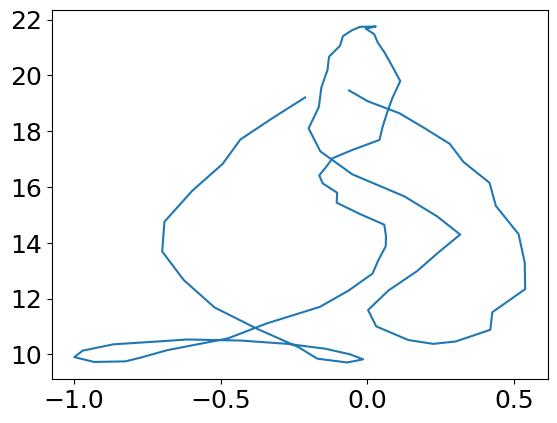

In [12]:
i = 520
traj = traj_list[i]
plt.plot(traj.x, traj.z)

# Set input & output variables

We want an estimator that takes the available sensor information and estimates the altitude. Since our model assumes that the camera is on a gimble and is always pointed down, $\theta$ is irrelevant.

In [13]:
output_names = ['z']

In [14]:
input_names =  ['sensor_optic_flow', 'sensor_accel_x', 'sensor_accel_z']

# Augment data so each row contains delay-embedded inputs and the outputs

We will collect inputs from a time window leading up to the final time point for which we want to estimate the altitude. This ensures that there is, theoretically, enough information to actually estimate the altitude, provided the time window contains enough dynamic movement to ensure observability.

This function was written with more generality in mind so we can reuse it later in scenarios where we have states and controls, and may want to consider them seperately.

In [15]:
# This function was written by Ben Cellini, and subsequently expanded by Claude to provide further functionality
def collect_offset_rows(df, states=None, controls=None, outputs=None,
                        state_offsets=None, control_offsets=None, output_offsets=None):
    """ Takes a pandas data frame with n rows and creates an augmented data frame that collects
        rows at specified offsets for different column types (states, controls, outputs).

        Inputs
            df: pandas data frame
            states: list of column names to treat as states
            controls: list of column names to treat as controls
            outputs: list of column names to treat as outputs
            state_offsets: list of integer offsets for state columns (default: [-1])
            control_offsets: list of integer offsets for control columns (default: [-1])
            output_offsets: list of integer offsets for output columns (default: [0])

            Offset interpretation:
                - Negative values look backward (e.g., -1 is previous row, -2 is two rows back)
                - Zero includes current row
                - Positive values look forward (e.g., 1 is next row, 2 is two rows ahead)

        Outputs
            df_aug: augmented pandas data frame.
                    Columns are organized by type and offset:
                    - First all state columns (grouped by offset)
                    - Then all control columns (grouped by offset)
                    - Finally all output columns (grouped by offset)
                    New columns are named: old_name_offset_N (e.g., 'x_offset_-1', 'u_offset_0')
                    Only rows where all offsets are valid are included.
    """
    import pandas as pd
    import numpy as np
    df = df.reset_index(drop=True)

    # Set defaults
    if state_offsets is None:
        state_offsets = [-1]
    if control_offsets is None:
        control_offsets = [-1]
    if output_offsets is None:
        output_offsets = [0]

    # Collect all columns and offsets to determine valid row range
    all_columns = []
    all_offsets = []

    column_groups = []
    if states is not None and len(states) > 0:
        all_columns.extend(states)
        all_offsets.extend(state_offsets)
        column_groups.append(('states', states, state_offsets))

    if controls is not None and len(controls) > 0:
        all_columns.extend(controls)
        all_offsets.extend(control_offsets)
        column_groups.append(('controls', controls, control_offsets))

    if outputs is not None and len(outputs) > 0:
        all_columns.extend(outputs)
        all_offsets.extend(output_offsets)
        column_groups.append(('outputs', outputs, output_offsets))

    if len(all_columns) == 0:
        raise ValueError("At least one of states, controls, or outputs must be specified")

    # Determine valid row range
    min_offset = min(all_offsets)
    max_offset = max(all_offsets)

    n_row = df.shape[0]

    # Valid rows are those where all offsets point to existing rows
    start_row = max(0, -min_offset)
    end_row = min(n_row, n_row - max_offset)
    n_row_train = end_row - start_row

    if n_row_train <= 0:
        raise ValueError(f"No valid rows with given offsets. DataFrame has {n_row} rows, "
                        f"but offsets range from {min_offset} to {max_offset}")

    # Build augmented dataframe by processing each column group
    df_aug_parts = []

    for group_name, columns, offsets in column_groups:
        # For each offset in this group
        for offset in offsets:
            source_indices = np.arange(start_row, end_row) + offset

            # For each column with this offset
            for col in columns:
                data = df.loc[source_indices, col].reset_index(drop=True)
                col_name = f'{col}_offset_{offset}'
                df_aug_parts.append(pd.DataFrame({col_name: data}))

    # Combine all parts
    df_aug = pd.concat(df_aug_parts, axis=1)

    return df_aug

### Perform the augmentation

In [16]:
# ignore the first and last few frames to prevent artifacts
trim_edges = 5

# use a time window of 10 steps -- adjust if you need larger windows for observability
time_window = 10

In [17]:
# construct the input offsets, and show them
input_offsets = np.arange(time_window)*-1
print(input_offsets)

[ 0 -1 -2 -3 -4 -5 -6 -7 -8 -9]


In [18]:
# we only need to estimate altitude at the final time step
output_offsets = [0]

In [19]:
# build a augmented trajectory for each trajectory in the list
traj_augment_list = []
for traj in traj_list:
    traj_augment = collect_offset_rows(traj[trim_edges:-1*trim_edges],
                                       states=input_names,
                                       controls=None,
                                       outputs=output_names,
                                       state_offsets=input_offsets,
                                       control_offsets=None,
                                       output_offsets=output_offsets)

    traj_augment_list.append(traj_augment)

# combine all the trajectories into a single data frame
traj_augment_all = pd.concat(traj_augment_list, ignore_index=True)

In [20]:
# display the data frame to see what the column names are
np.round(traj_augment_all, 4)

,sensor_optic_flow_offset_0,sensor_accel_x_offset_0,sensor_accel_z_offset_0,sensor_optic_flow_offset_-1,sensor_accel_x_offset_-1,sensor_accel_z_offset_-1,sensor_optic_flow_offset_-2,sensor_accel_x_offset_-2,sensor_accel_z_offset_-2,sensor_optic_flow_offset_-3,...,sensor_optic_flow_offset_-7,sensor_accel_x_offset_-7,sensor_accel_z_offset_-7,sensor_optic_flow_offset_-8,sensor_accel_x_offset_-8,sensor_accel_z_offset_-8,sensor_optic_flow_offset_-9,sensor_accel_x_offset_-9,sensor_accel_z_offset_-9,z_offset_0
0,-2.0871,13.6681,3.8775,-3.0789,13.9965,4.1668,-3.6382,13.2772,3.4782,-3.8035,...,-3.4928,4.2851,-5.1520,-3.4474,3.0591,-6.7268,-3.4200,1.5298,-7.7760,0.7807
1,-0.4845,12.6933,2.8999,-2.0871,13.6681,3.8775,-3.0789,13.9965,4.1668,-3.6382,...,-3.6370,5.5118,-3.1128,-3.4928,4.2851,-5.1520,-3.4474,3.0591,-6.7268,0.6973
2,1.4552,10.0497,3.1857,-0.4845,12.6933,2.8999,-2.0871,13.6681,3.8775,-3.0789,...,-3.7636,7.7547,-1.2477,-3.6370,5.5118,-3.1128,-3.4928,4.2851,-5.1520,0.5771
3,3.1353,4.9735,4.3434,1.4552,10.0497,3.1857,-0.4845,12.6933,2.8999,-2.0871,...,-3.8139,10.1720,0.3878,-3.7636,7.7547,-1.2477,-3.6370,5.5118,-3.1128,0.5365
4,3.7364,0.7021,3.6585,3.1353,4.9735,4.3434,1.4552,10.0497,3.1857,-0.4845,...,-3.8035,12.0309,2.2048,-3.8139,10.1720,0.3878,-3.7636,7.7547,-1.2477,0.5101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207599,-0.7323,6.6710,-0.2964,-1.7715,5.9074,0.1903,-2.5599,3.5971,1.0243,-2.7201,...,1.0576,-5.1992,0.2043,1.3785,-0.1712,1.4003,1.0105,5.3886,0.0301,0.5944
207600,0.4518,6.8773,-0.6126,-0.7323,6.6710,-0.2964,-1.7715,5.9074,0.1903,-2.5599,...,0.1404,-7.9438,-1.2628,1.0576,-5.1992,0.2043,1.3785,-0.1712,1.4003,0.5479
207601,1.6711,6.9776,-0.5823,0.4518,6.8773,-0.6126,-0.7323,6.6710,-0.2964,-1.7715,...,-0.9757,-7.9927,-1.3315,0.1404,-7.9438,-1.2628,1.0576,-5.1992,0.2043,0.5164
207602,3.0312,6.3397,0.1003,1.6711,6.9776,-0.5823,0.4518,6.8773,-0.6126,-0.7323,...,-2.0402,-5.4479,0.3426,-0.9757,-7.9927,-1.3315,0.1404,-7.9438,-1.2628,0.5300


### Calculate the number of inputs and outputs

For the neural network with augmented data, we now have more inputs corresponding to the time-history of sensory measurements

In [21]:
n_input = len(input_names) * time_window
n_output = len(output_names)

print('Inputs:', n_input)
print('Output:', n_output)

Inputs: 30
Output: 1


### Seperate inputs & outputs

In [22]:
# Input data
X = traj_augment_all.iloc[:, 0:n_input]
X

,sensor_optic_flow_offset_0,sensor_accel_x_offset_0,sensor_accel_z_offset_0,sensor_optic_flow_offset_-1,sensor_accel_x_offset_-1,sensor_accel_z_offset_-1,sensor_optic_flow_offset_-2,sensor_accel_x_offset_-2,sensor_accel_z_offset_-2,sensor_optic_flow_offset_-3,...,sensor_accel_z_offset_-6,sensor_optic_flow_offset_-7,sensor_accel_x_offset_-7,sensor_accel_z_offset_-7,sensor_optic_flow_offset_-8,sensor_accel_x_offset_-8,sensor_accel_z_offset_-8,sensor_optic_flow_offset_-9,sensor_accel_x_offset_-9,sensor_accel_z_offset_-9
0,-2.087088,13.668071,3.877476,-3.078905,13.996512,4.166833,-3.638208,13.277199,3.478190,-3.803452,...,-3.112825,-3.492841,4.285081,-5.152013,-3.447425,3.059079,-6.726785,-3.420002,1.529765,-7.775982
1,-0.484517,12.693342,2.899917,-2.087088,13.668071,3.877476,-3.078905,13.996512,4.166833,-3.638208,...,-1.247694,-3.636994,5.511816,-3.112825,-3.492841,4.285081,-5.152013,-3.447425,3.059079,-6.726785
2,1.455247,10.049670,3.185739,-0.484517,12.693342,2.899917,-2.087088,13.668071,3.877476,-3.078905,...,0.387830,-3.763601,7.754718,-1.247694,-3.636994,5.511816,-3.112825,-3.492841,4.285081,-5.152013
3,3.135330,4.973507,4.343403,1.455247,10.049670,3.185739,-0.484517,12.693342,2.899917,-2.087088,...,2.204776,-3.813935,10.171985,0.387830,-3.763601,7.754718,-1.247694,-3.636994,5.511816,-3.112825
4,3.736363,0.702080,3.658491,3.135330,4.973507,4.343403,1.455247,10.049670,3.185739,-0.484517,...,3.478190,-3.803452,12.030914,2.204776,-3.813935,10.171985,0.387830,-3.763601,7.754718,-1.247694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207599,-0.732323,6.670987,-0.296412,-1.771544,5.907399,0.190341,-2.559909,3.597102,1.024328,-2.720075,...,-1.262832,1.057641,-5.199236,0.204278,1.378485,-0.171183,1.400295,1.010483,5.388604,0.030087
207600,0.451778,6.877296,-0.612591,-0.732323,6.670987,-0.296412,-1.771544,5.907399,0.190341,-2.559909,...,-1.331539,0.140356,-7.943818,-1.262832,1.057641,-5.199236,0.204278,1.378485,-0.171183,1.400295
207601,1.671071,6.977577,-0.582338,0.451778,6.877296,-0.612591,-0.732323,6.670987,-0.296412,-1.771544,...,0.342614,-0.975709,-7.992657,-1.331539,0.140356,-7.943818,-1.262832,1.057641,-5.199236,0.204278
207602,3.031208,6.339746,0.100314,1.671071,6.977577,-0.582338,0.451778,6.877296,-0.612591,-0.732323,...,1.536016,-2.040162,-5.447879,0.342614,-0.975709,-7.992657,-1.331539,0.140356,-7.943818,-1.262832


In [23]:
# Output data
Y = traj_augment_all.iloc[:, n_input:]
Y

,z_offset_0
0,0.780735
1,0.697315
2,0.577083
3,0.536504
4,0.510063
...,...
207599,0.594382
207600,0.547874
207601,0.516362
207602,0.530017


# Construct neural network model
We will start with a basic feedforward network structure with three dense hidden layers.

A detailed guide to layer types, activation functions, loss functions, etc. can be found here: https://keras.io/api/layers/



In [24]:
model = Sequential() # sequential model means that each layer has one set of inputs & one set of outputs (no recurrence)
model.add(Dense(50, input_dim=n_input, activation='relu')) # add a dense layer with 50 neurons & rectified linear unit (ReLU) activation function
model.add(Dense(50, activation='relu')) # add a dense layer with 50 neurons & ReLU activation function
model.add(Dense(20, activation='relu')) # add a dense layer with 20 neurons & ReLU) activation function
model.add(Dense(n_output, activation='linear')) # add output layer with linear activation function for regression

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compile the model: set the loss function & optimizer

In [25]:
model.compile(loss='mean_squared_error', # set the loss function
              optimizer='adam', # optimzer (stochastic gradient descent method: https://arxiv.org/abs/1412.6980)
              metrics=['mean_absolute_error']) # list of other metrics to compute when traning

Model structure

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │         1,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,141 (20.08 KB)

 Trainable params: 5,141 (20.08 KB)

 Non-trainable params: 0 (0.00 B)

### Visualize the model
Note the image displayed below shows truncated hidden layers

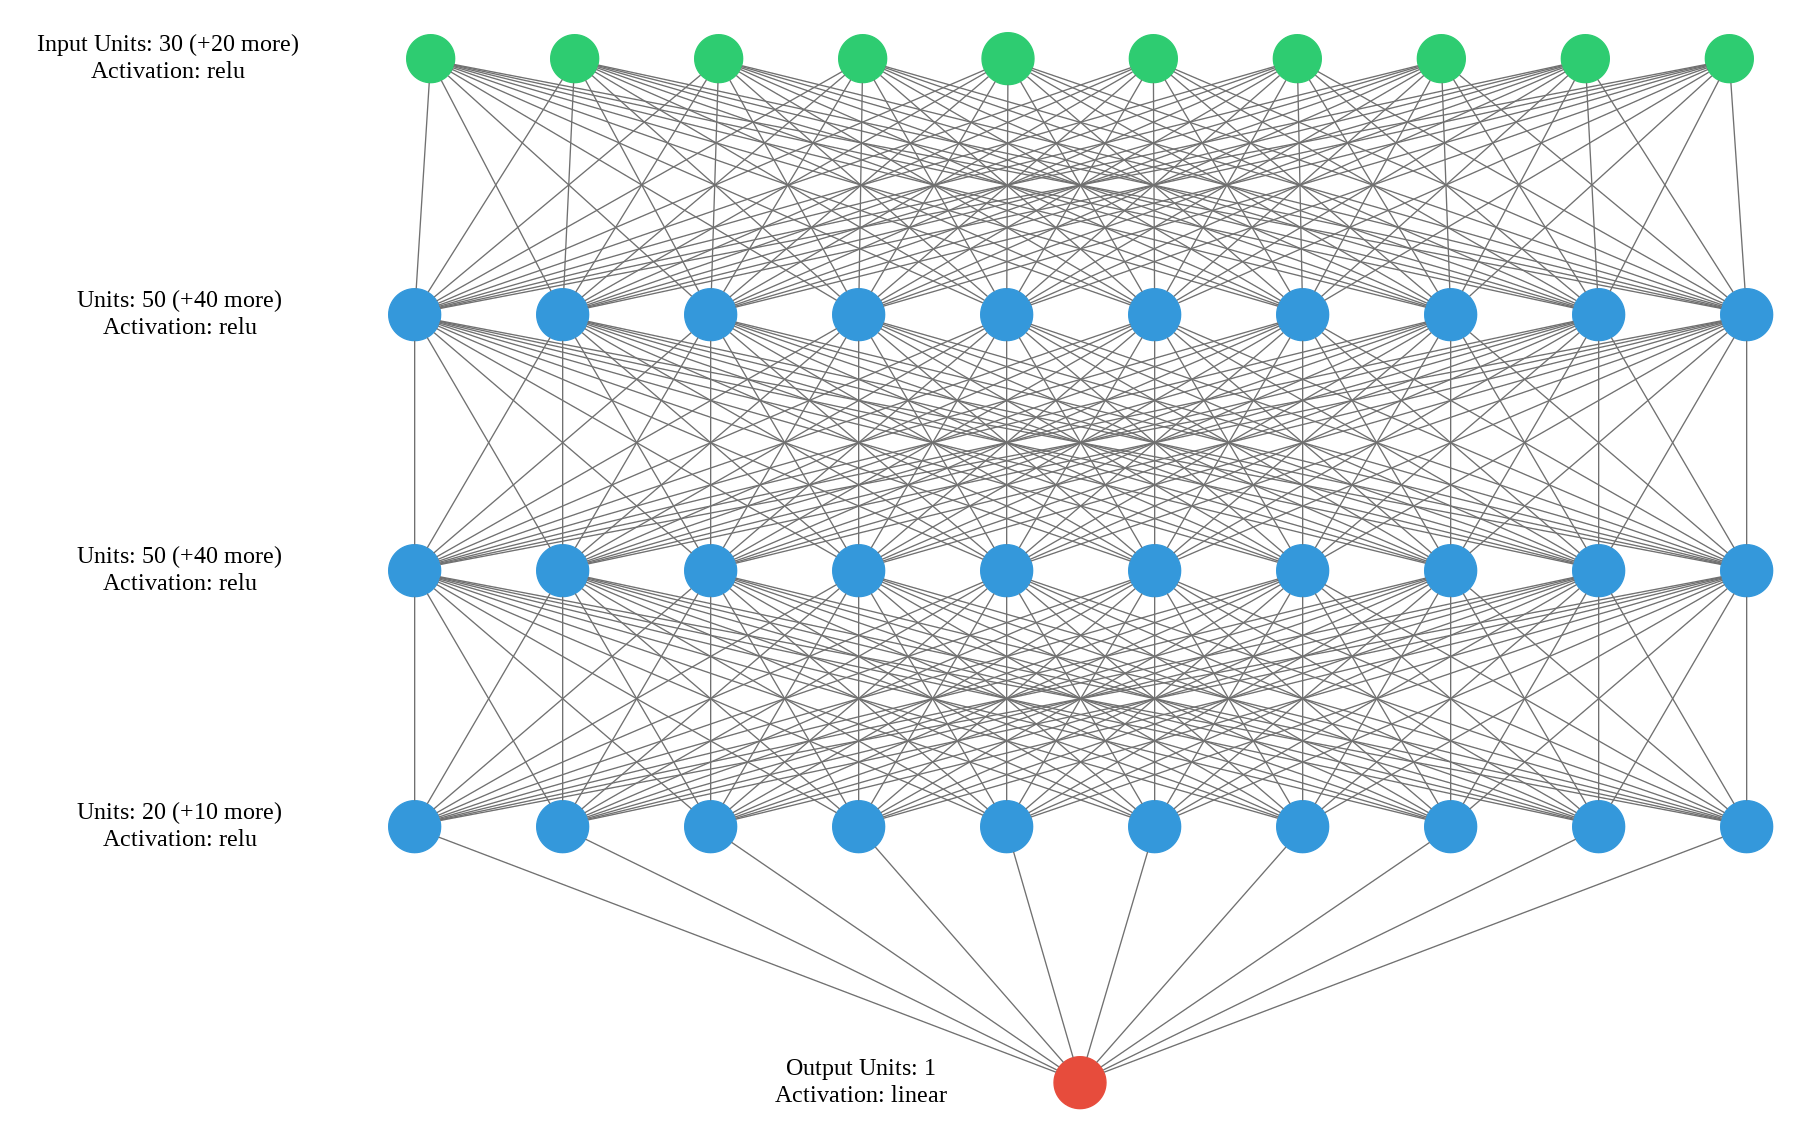

In [27]:
visualizer(model, file_format='png', view=False) # saves an image: graph.png
display(Image(filename='graph.png'))

# Train model
***This will take a little while to run. It will be faster on a GPU runtime.***

The `batch_size` hyperparameter sets the number of samples used during training before updating the model. Larger batch sizes will train faster but may be less stable/accurate.

The `epochs` hyperparameter sets the number of iterations the model will train over the entire dataset. More epochs will generally improve accuracy, but has diminishing returns over time.

The `validation_split` hyperparameter specifies what ratio of your training data that is withheld during training to test the network accuracy.

`verbose` just sets how much output to display and does not affect the model itself.

### Show if the GPU is being used.

In [28]:
import subprocess

# from Claude
class GPUMonitor(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 1 == 0:  # Check every 5 epochs
            try:
                result = subprocess.run(['nvidia-smi', '--query-gpu=utilization.gpu,memory.used,memory.total',
                                      '--format=csv,noheader,nounits'],
                                      capture_output=True, text=True)
                gpu_util, mem_used, mem_total = result.stdout.strip().split(', ')
                print(f"\n[GPU] Utilization: {gpu_util}%, Memory: {mem_used}/{mem_total} MB")
            except:
                print(f"\nNo GPU found")

In [29]:
model_data = model.fit(X, Y, epochs=75, batch_size=256, validation_split=0.2, verbose=1,
                       callbacks=[GPUMonitor()])

Epoch 1/75
649/649 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 49.8865 - mean_absolute_error: 5.4198
[GPU] Utilization: 31%, Memory: 376/15360 MB
649/649 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 49.8638 - mean_absolute_error: 5.4183 - val_loss: 17.7964 - val_mean_absolute_error: 3.1630
Epoch 2/75
645/649 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19.7530 - mean_absolute_error: 3.0843
[GPU] Utilization: 2%, Memory: 376/15360 MB
649/649 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 19.7392 - mean_absolute_error: 3.0828 - val_loss: 11.9446 - val_mean_absolute_error: 2.3943
Epoch 3/75
641/649 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.6516 - mean_absolute_error: 2.4715
[GPU] Utilization: 3%, Memory: 376/15360 MB
649/649 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 14.6451 - mean_absolute_error: 2.4704 - val_loss: 10.1242 - val_mean_absolute_error: 2.1416
Epoch 4/75
641/649 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.7323 - mean_absolute_error: 2.2091
[GPU] Utilization: 3%, Memory: 376/15360 MB
649/649 

# Evaluate the training and model

### Loss function over time

This curves should go down, and the red curve should remain below the blue curve. If the red curve goes above the blue curve, you are overfitting the model.

Text(0, 0.5, 'loss')

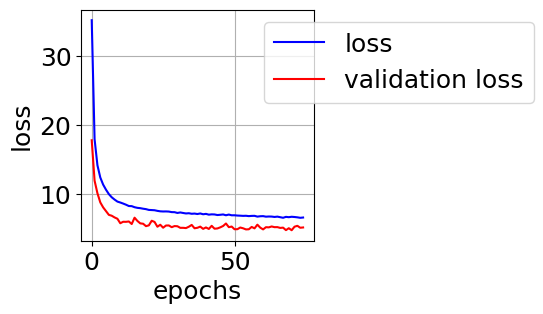

In [40]:
model_history = pd.DataFrame(model_data.history)

fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=100)

ax.plot(model_history.loss,
        '-',
        label='loss',
        color='blue')

ax.plot(model_history.val_loss,
        '-',
        label='validation loss',
        color='red')

ax.grid()
ax.legend(bbox_to_anchor=(2.0, 1.0))

ax.set_xlabel('epochs')
ax.set_ylabel('loss')

### Evaluate training accuracy

Run model on training data. We will speed this up in the next notebook.

In [41]:
Y_predict = model.predict(X, batch_size=4096)

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Plot a distribution of the error.

In [42]:
z_predict = Y_predict[:,0]
z_true = Y['z_offset_0'].values

In [43]:
z_error = z_predict - z_true
z_mean_error = np.mean(z_error)
z_std_error = np.std(z_error)
print('mean error:', np.round(z_mean_error, 4))
print('mean std:', np.round(z_std_error, 4))

mean error: 0.1341
mean std: 2.4868


Text(0, 0.5, 'Count')

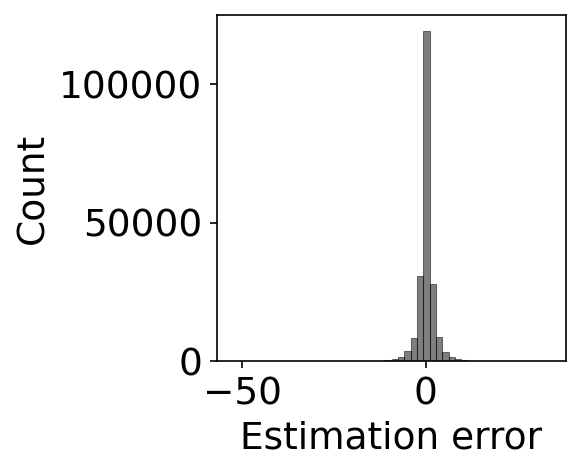

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=150)
hist_data = ax.hist(z_error, bins=50, facecolor='black', alpha=0.5, edgecolor='black', linewidth=0.5)
ax.set_xlabel('Estimation error')
ax.set_ylabel('Count')

Plot a comparison of the true vs predicted.

Text(0.5, 0, 'True z')

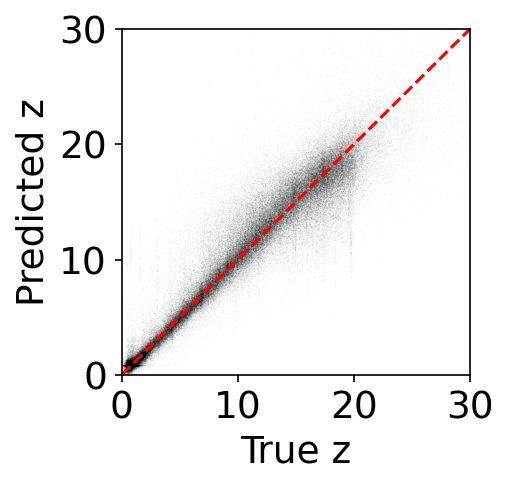

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=150)

z_line = np.arange(np.min(z_true), np.max(z_true), 1)


ax.scatter(z_true, z_predict, s=0.2, c='black', alpha=0.05, edgecolors='none')
ax.plot(z_line, z_line, '--', color='red')

ax.set_xlim(0, 30)
ax.set_ylim(0, 30)

ax.set_ylabel('Predicted z')
ax.set_xlabel('True z')

Plot a distribution of errors as a function of acceleration. Here you can see the manifestation of observability implications.

In [46]:
cols = [col for col in X if col.startswith('sensor_accel_x')]
mean_accels = X[cols].mean(axis=1)

In [47]:
min_accels = np.abs(X[cols]).min(axis=1)

Text(0, 0.5, 'altitude error')

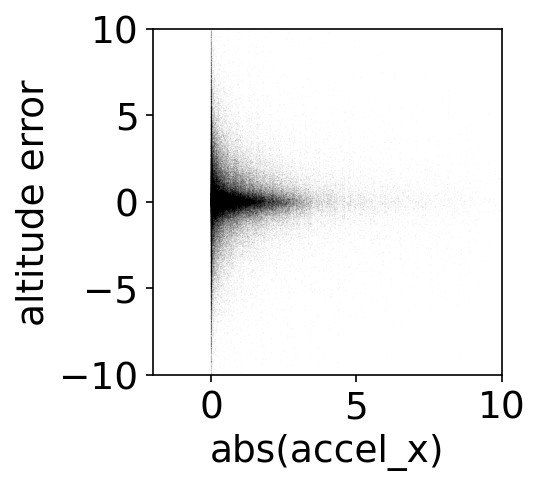

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=150)

ax.scatter(min_accels, z_error, s=0.2, c='black', alpha=0.05, edgecolors='none')

ax.set_ylim(-10, 10)
ax.set_xlim(-2, 10)

ax.set_xlabel('abs(accel_x)')
ax.set_ylabel('altitude error')

# Save model

In [49]:
model_path = 'altitude_estimator_network_trained.keras' # download this, or change location to google drive to save indefinitely
model.save(model_path)